# Investigating linear solvers options on flow problem with random fractures

Import necessery packages:

In [1]:
import numpy as np
import porepy as pp
import FTHM_Solver
import scipy.stats as stats
from pprint import pprint


And few additional ones

In [2]:
import time
import pandas as pd
import copy
from joblib import Parallel, delayed, parallel_backend
import itertools
import gmsh

import math
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt


This bit is from flow_setup.py

In [3]:
from porepy.examples.flow_benchmark_2d_case_4 import (
    FlowBenchmark2dCase4Model,
    solid_constants as solid_constants_2d,
)


class StochasticGeometry:
    def set_fractures(self):
        np.random.seed(self.params.get("seed", 42))

        num_fractures = self.params.get("num_fractures", 10)

        # Generate random fracture orientations. For now, we assume uniform distribution
        # of orientations in the range [0, pi]. We may change this later.
        orientation_distr = stats.uniform(loc=0, scale=np.pi)
        orientation = orientation_distr.rvs(size=num_fractures)

        # Represent fracture lengths as a log-normal distribution. The parameters set
        # here are quite random.
        length_distr = stats.lognorm(s=1, scale=0.5)
        lengths = length_distr.rvs(size=num_fractures)

        # Generate random fracture centers. For now, we assume uniform distribution
        # of positions in the range [0, 1] in both x and y directions.
        position_distr = stats.uniform(loc=0, scale=1)
        positions_x = position_distr.rvs(size=num_fractures)
        positions_y = position_distr.rvs(size=num_fractures)

        # Create the endpoints of the fractures based on the lengths and orientations.
        endpoints = []
        for i in range(num_fractures):
            cx = positions_x[i]
            cy = positions_y[i]
            length = lengths[i]
            theta = orientation[i]

            x0 = cx - 0.5 * length * np.cos(theta)
            y0 = cy - 0.5 * length * np.sin(theta)

            p0 = np.array([x0, y0]).reshape((2, 1))

            x1 = cx + 0.5 * length * np.cos(theta)
            y1 = cy + 0.5 * length * np.sin(theta)
            p1 = np.array([x1, y1]).reshape((2, 1))

            endpoints.append(np.hstack([p0, p1]))

        # Create the fractures as line segments.
        fractures = []
        for point_pairs in endpoints:
            fractures.append(pp.LineFracture(point_pairs))

        # Set the fractures in the model.
        self._fractures = fractures

    def grid_type(self):
        return "simplex"


class Source:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        domain = self.domain
        box = domain.bounding_box_from_polytope()

        x_mean = (box["xmax"] + box["xmin"]) / 2
        y_mean = (box["ymax"] + box["ymin"]) / 2

        src_ambient = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd)
        )
        src_fracture = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd - 1)
        )
        src_intersection = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim < self.nd - 1)
        )

        if len(self._fractures) == 0:
            # Domain without fractures. Put the source in the center of the domain.
            sd = subdomains[0]
            closest_cell = sd.closest_cell(
                np.array([x_mean, y_mean, 0]).reshape((3, 1))
            )
            src_ambient[closest_cell] = 1.0
        else:
            x, y, z = np.concatenate(
                [sd.cell_centers for sd in subdomains if sd.dim == self.nd - 1], axis=1
            )
            source_loc = np.argmin((x - x_mean) ** 2 + (y - y_mean) ** 2)
            src_fracture[source_loc] = 1

        return super().fluid_source(subdomains) + pp.ad.DenseArray(
            np.concatenate([src_ambient, src_fracture, src_intersection])
        )


class ModelProperties:
    def _is_nonlinear_problem(self) -> bool:
        """Check if the model is nonlinear."""
        return False


class StochasticModel(
    StochasticGeometry,
    FTHM_Solver.IterativeSolverMixin,
    Source,
    ModelProperties,
    pp.SinglePhaseFlow,
):
    pass


class BenchmarkModel(
    Source,
    FTHM_Solver.IterativeSolverMixin,
    ModelProperties,
    FlowBenchmark2dCase4Model,
):
    # We may want to look at this at some point, but for now, consider it untested and
    # optional.
    pass


if True:
    model_class = StochasticModel
else:
    model_class = BenchmarkModel


def reset_model_state(model):
    """Reset the model state to a clean state.

    This can be useful to run several simulations with the same model (discretization
    etc.) but, say, with different solver parameters.
    """
    mdg = model.mdg

    num_cells = sum(sd.num_cells for sd in mdg.subdomains())
    num_interface_cells = sum(intf.num_cells for intf in mdg.interfaces())

    zeros = np.zeros(num_cells + num_interface_cells, dtype=float)
    model.equation_system.set_variable_values(
        values=zeros, additive=False, time_step_index=0
    )
    model.equation_system.set_variable_values(
        values=zeros, additive=False, iterate_index=0
    )

    model.time_manager = pp.TimeManager(schedule=[0, 1], dt_init=1, constant_dt=True)

"mesh_arguments" are not forced atm

In [4]:
model_params = {
    "solid_constants": solid_constants_2d,
    "linear_solver": {"preconditioner_factory": FTHM_Solver.mass_balance_factory},
    # Control the number of fractures here.
    "num_fractures": 11,
    # This is the simplest way to control the cell size. You can also do
    # 'cell_size_fracture' and 'cell_size_boundary'.
   # "meshing_arguments": {"cell_size": 0.2,
                          #"cell_size_min": 0.05,         # avoid too-small elements
                          #"cell_size_fracture": 0.1,    # fine mesh around fractures
                          #"cell_size_fracture_min": 0.0045,    # fine mesh around fractures
                          #"cell_size_boundary": 0.2      # coarser mesh at outer boundary
    #                     },
    # Control the name of the gmsh file here.
    "meshing_kwargs": {"file_name": "mesh_2d"}
}


Model initialization

In [5]:
model = model_class(model_params)
model.prepare_simulation()


linear_solver_opts = {
    # This line PETSc print the residual norm at each iteration.
    #"ksp_monitor": None,
    #"ksp_view": None,
    "ksp_type": 'bcgs',#"preonly",#"tfqmr1",#"gmres1", #"richardson0", #"bicg0", #"bcgs1",  # Change the Krylov method
    "interface_darcy_flux": {"pc_type": "lu"}, # fix this to ilu for now
    "mass_balance": {"pc_type": "lu"},
}

model.params["linear_solver"].update({"options": linear_solver_opts})



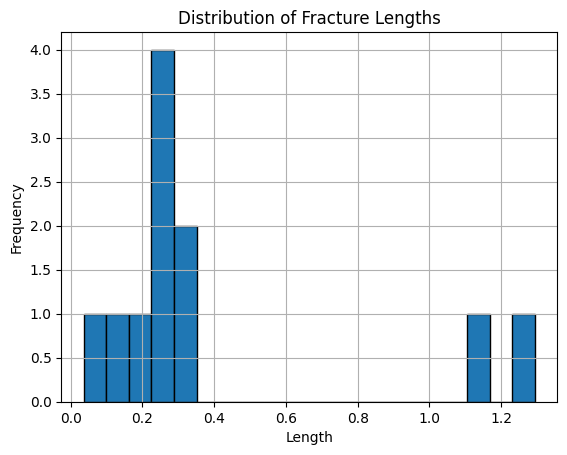


 Smallest fracture: 0.0367


In [6]:
# Compute actual lengths of the generated fractures
fractures = model.fractures
actual_lengths = [
    np.linalg.norm(frac.pts[:, 1] - frac.pts[:, 0])
    for frac in fractures
]

plt.hist(actual_lengths, bins=20, edgecolor='black')
plt.title("Distribution of Fracture Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Recommend cell size near fractures
min_length = min(actual_lengths)

print(f"\n Smallest fracture: {min_length:.4f}")

In [7]:
try:
    pp.run_time_dependent_model(model, {"prepare_simulation": False})
    pprint(f"Simulation completed successfully with {model._krylov_iters} iterations.")
except Exception as e:
        print(f"Solver failed!")
        print(f" Error: {e}")
    

'Simulation completed successfully with [4] iterations.'


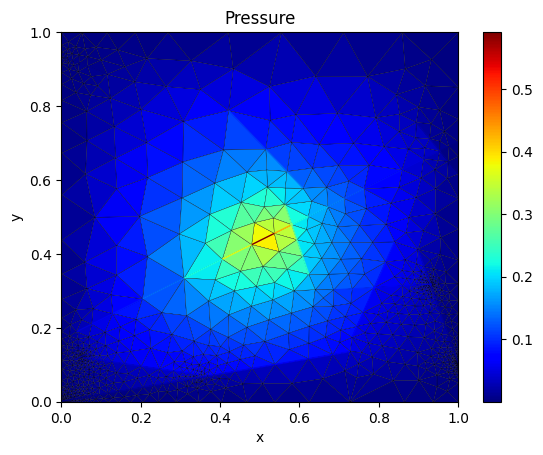

In [8]:
#%%
pp.plot_grid(
    model.mdg,
    "pressure",
    figsize=(10, 8),
    linewidth=0.2,
    title='Pressure',
    plot_2d=True,
)

In [9]:
model._krylov_iters=[0]
model._solve_time=[0]
model._construction_time=[0]

In [10]:

# Define solver types and preconditioners
ksp_types = ["gmres", "bcgs", "tfqmr"]
preconditioners_mass = ["ilu", "lu", "sor", "jacobi", "bjacobi", "asm",  "gamg"]
preconditioners_interface = ["ilu", "lu", "sor"]

# Generate all combinations
solver_combinations = list(itertools.product(ksp_types, preconditioners_interface,preconditioners_mass))

# Store results
results = []

for idx, (ksp, pc_interface, pc_mass) in enumerate(solver_combinations):
    print(f"\n➡️ Running combination #{idx + 1}: {ksp} + {pc_mass} + {pc_interface}")
    
    reset_model_state(model)
    
    linear_solver_opts = {
        "ksp_type": ksp,
        "interface_darcy_flux": {"pc_type": pc_interface},
        "mass_balance": {"pc_type": pc_mass}
    }
   
    model.params["linear_solver"].update({"options": linear_solver_opts})
      
    try:
        model = model_class(model_params)
        model.prepare_simulation()
        start = time.time()
        pp.run_time_dependent_model(model, {"prepare_simulation": False})
        end = time.time()

        results.append({
            "Combination #": idx,
            "KSP Type": ksp,
            "PC Mass": pc_mass,
            "PC Interface": pc_interface,
            "Converged": True,
            "Krylov Iters": model._krylov_iters[-1],
            "Construction Time (s)": model._construction_time[-1],
            "Solve Time (s)": model._solve_time[-1],
            "Total Time (s)": model._construction_time[-1] + model._solve_time[-1],
            "Tic Toc Time (s)": end - start
            })
      
    except Exception as e:
        print(f"❌ Combination #{idx+1} failed: {ksp} + {pc_mass} + {pc_interface}")
        print(f"   ⚠️ Error: {type(e).__name__}: {e}")
        # print(f" Error: {e}")
        results.append({
            "Combination #": idx,
            "KSP Type": ksp,
            "PC Mass": pc_mass,
            "PC Interface": pc_interface,
            "Converged": False,
            "Krylov Iters": None,
            "Construction Time (s)": None,
            "Solve Time (s)": None,
            "Total Time (s)": None,
            "Tic Toc Time (s)": None
            })
    
# Convert results to DataFrame and save
df_results = pd.DataFrame(results)




➡️ Running combination #1: gmres + ilu + ilu
Running combination #1: gmres + ilu + ilu


➡️ Running combination #2: gmres + lu + ilu
Running combination #2: gmres + lu + ilu


➡️ Running combination #3: gmres + sor + ilu
Running combination #3: gmres + sor + ilu

❌ Combination #3 failed: gmres + sor + ilu
   ⚠️ Error: RuntimeError: Solver did not converge. Reason: -3. Check the solver options and the problem setup.

➡️ Running combination #4: gmres + jacobi + ilu
Running combination #4: gmres + jacobi + ilu

❌ Combination #4 failed: gmres + jacobi + ilu
   ⚠️ Error: RuntimeError: Solver did not converge. Reason: -3. Check the solver options and the problem setup.

➡️ Running combination #5: gmres + bjacobi + ilu
Running combination #5: gmres + bjacobi + ilu


➡️ Running combination #6: gmres + asm + ilu
Running combination #6: gmres + asm + ilu


➡️ Running combination #7: gmres + gamg + ilu
Running combination #7: gmres + gamg + ilu


➡️ Running combination #8: gmres + ilu + lu
Runni

In [11]:
df_results

,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s)
0,0,gmres,ilu,ilu,True,54.0,0.003422,0.006837,0.010259,0.216645
1,1,gmres,lu,ilu,True,7.0,0.009371,0.001429,0.010799,0.239506
2,2,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN
3,3,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN
4,4,gmres,bjacobi,ilu,True,54.0,0.003035,0.007036,0.010071,0.170656
...,...,...,...,...,...,...,...,...,...,...
58,58,tfqmr,sor,sor,False,NaN,NaN,NaN,NaN,NaN
59,59,tfqmr,jacobi,sor,False,NaN,NaN,NaN,NaN,NaN
60,60,tfqmr,bjacobi,sor,True,70.0,0.003170,0.005003,0.008173,0.199352
61,61,tfqmr,asm,sor,True,70.0,0.003699,0.005091,0.008790,0.234226


In [12]:
df_results.head()

,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s)
0,0,gmres,ilu,ilu,True,54.0,0.003422,0.006837,0.010259,0.216645
1,1,gmres,lu,ilu,True,7.0,0.009371,0.001429,0.010799,0.239506
2,2,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN
3,3,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN
4,4,gmres,bjacobi,ilu,True,54.0,0.003035,0.007036,0.010071,0.170656


In [13]:
df_results.iloc[41:-1]

,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s)
41,41,bcgs,gamg,sor,True,22.0,0.009077,0.008959,0.018036,0.191327
42,42,tfqmr,ilu,ilu,True,74.0,0.003408,0.004498,0.007906,0.176666
43,43,tfqmr,lu,ilu,True,8.0,0.009705,0.001579,0.011284,0.176254
44,44,tfqmr,sor,ilu,True,175.0,0.003293,0.011687,0.014979,0.199326
45,45,tfqmr,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN
46,46,tfqmr,bjacobi,ilu,True,74.0,0.004727,0.006739,0.011466,0.194031
47,47,tfqmr,asm,ilu,True,74.0,0.005058,0.006263,0.011321,0.208225
48,48,tfqmr,gamg,ilu,True,50.0,0.011580,0.010993,0.022572,0.215150
49,49,tfqmr,ilu,lu,True,73.0,0.003582,0.004759,0.008341,0.177090
50,50,tfqmr,lu,lu,True,8.0,0.011367,0.001853,0.013220,0.266232


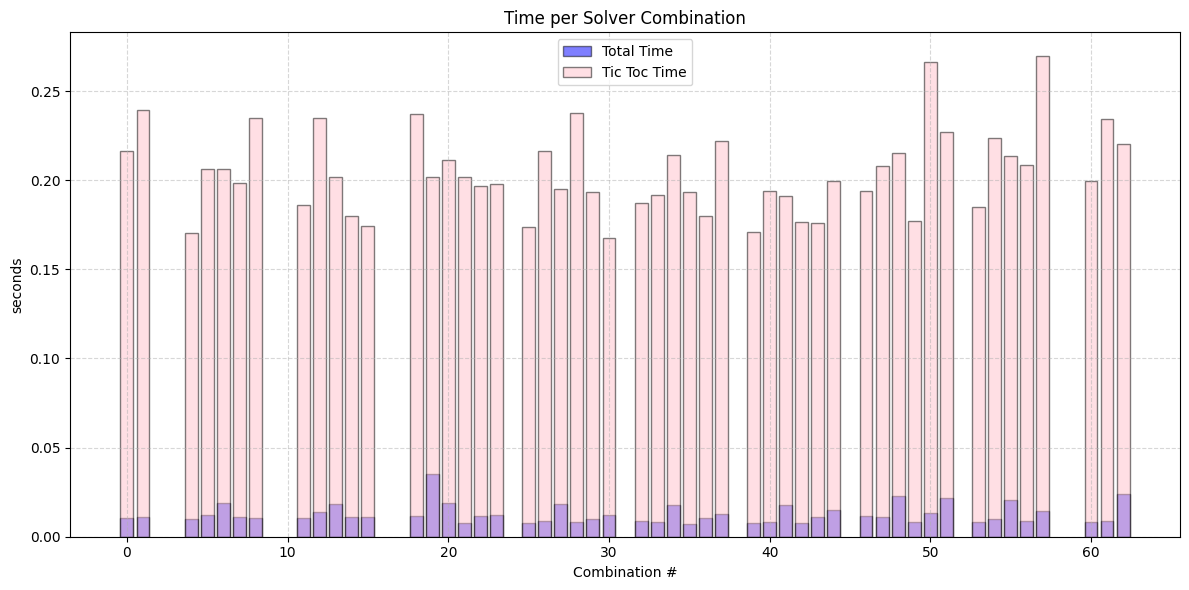

In [15]:

plt.figure(figsize=(12, 6))
plt.bar(df_results["Combination #"], df_results["Total Time (s)"], color="blue", edgecolor="k", alpha=0.5, label="Total Time")
plt.bar(df_results["Combination #"], df_results["Tic Toc Time (s)"], color="pink", edgecolor="k", alpha=0.5,  label="Tic Toc Time")
#plt.bar(df_results2["Combination #"], df_results2["Time (s)"], color="yellow", edgecolor="k", alpha=0.5)
plt.xlabel("Combination #")
plt.ylabel("seconds")
plt.title("Time per Solver Combination")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_51518/2487395085.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flux_ilu["label"] = df_flux_ilu["KSP Type"] + " + " + df_flux_ilu["PC Mass"]


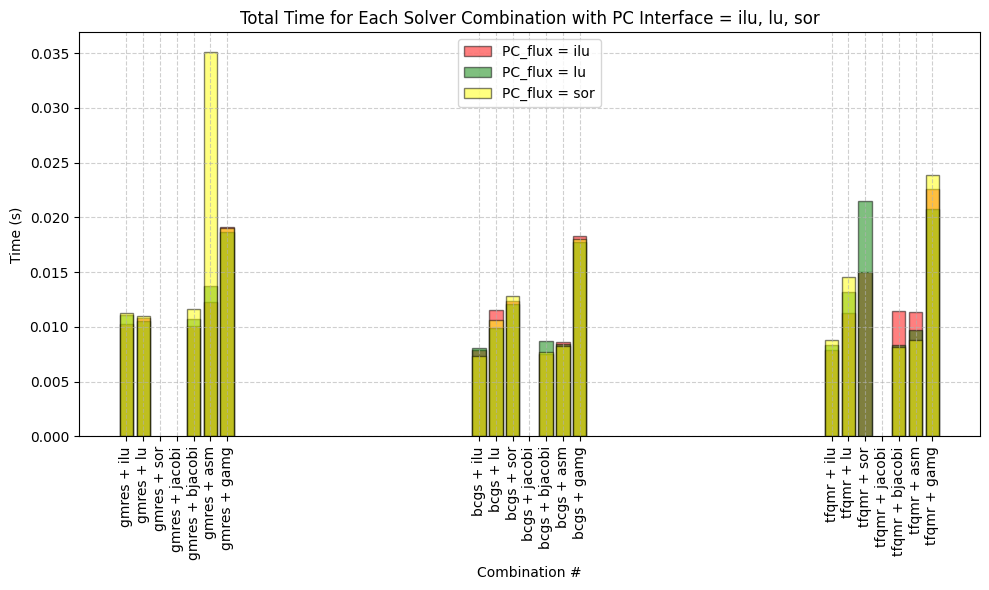

In [16]:

# Filter to combinations where PC Interface == 'ilu' and Total Time is valid
df_flux_ilu = df_results[df_results["PC Interface"] == "ilu" ]
df_flux_lu = df_results[df_results["PC Interface"] == "lu"] 
df_flux_sor = df_results[df_results["PC Interface"] == "sor"] 

df_flux_ilu["label"] = df_flux_ilu["KSP Type"] + " + " + df_flux_ilu["PC Mass"]


# Plot Total Time for each combination
plt.figure(figsize=(10, 6))
plt.bar(df_flux_ilu["Combination #"], df_flux_ilu["Total Time (s)"], color="red", edgecolor="k",alpha=0.5, label='PC_flux = ilu' )
plt.bar(df_flux_ilu["Combination #"], df_flux_lu["Total Time (s)"], color="green", edgecolor="k", alpha=0.5, label='PC_flux = lu')
plt.bar(df_flux_ilu["Combination #"], df_flux_sor["Total Time (s)"], color="yellow", edgecolor="k", alpha=0.5, label='PC_flux = sor')
plt.xlabel("Combination #")
plt.ylabel("Time (s)")
plt.legend()
plt.title("Total Time for Each Solver Combination with PC Interface = ilu, lu, sor")
#plt.xticks(df_flux_ilu["Combination #"], rotation=90)
plt.xticks(ticks=df_flux_ilu["Combination #"], labels=df_flux_ilu["label"], rotation=90)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


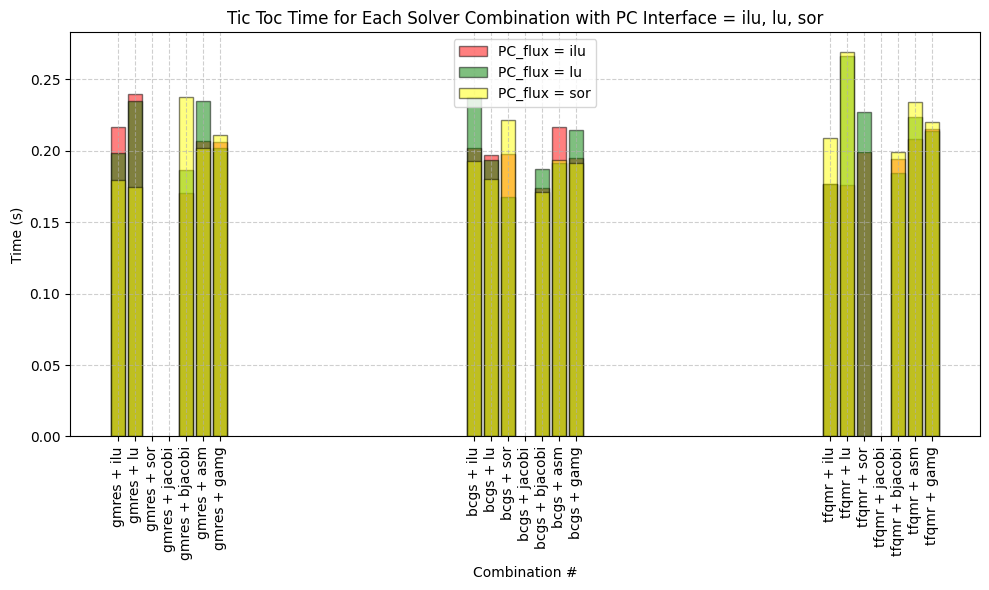

In [17]:


# Plot Total Time for each combination
plt.figure(figsize=(10, 6))
plt.bar(df_flux_ilu["Combination #"], df_flux_ilu["Tic Toc Time (s)"], color="red", edgecolor="k",alpha=0.5, label='PC_flux = ilu' )
plt.bar(df_flux_ilu["Combination #"], df_flux_lu["Tic Toc Time (s)"], color="green", edgecolor="k", alpha=0.5, label='PC_flux = lu')
plt.bar(df_flux_ilu["Combination #"], df_flux_sor["Tic Toc Time (s)"], color="yellow", edgecolor="k", alpha=0.5, label='PC_flux = sor')
plt.xlabel("Combination #")
plt.ylabel("Time (s)")
plt.legend()
plt.title("Tic Toc Time for Each Solver Combination with PC Interface = ilu, lu, sor")
#plt.xticks(df_flux_ilu["Combination #"], rotation=90)
plt.xticks(ticks=df_flux_ilu["Combination #"], labels=df_flux_ilu["label"], rotation=90)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
df_flux_ilu

,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),label
0,0,gmres,ilu,ilu,True,54.0,0.003422,0.006837,0.010259,0.216645,gmres + ilu
1,1,gmres,lu,ilu,True,7.0,0.009371,0.001429,0.010799,0.239506,gmres + lu
2,2,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + sor
3,3,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi
4,4,gmres,bjacobi,ilu,True,54.0,0.003035,0.007036,0.010071,0.170656,gmres + bjacobi
5,5,gmres,asm,ilu,True,54.0,0.004110,0.008175,0.012285,0.206527,gmres + asm
6,6,gmres,gamg,ilu,True,34.0,0.009224,0.009926,0.019150,0.206023,gmres + gamg
21,21,bcgs,ilu,ilu,True,33.0,0.003821,0.004039,0.007860,0.201927,bcgs + ilu
22,22,bcgs,lu,ilu,True,4.0,0.010257,0.001286,0.011543,0.196751,bcgs + lu
23,23,bcgs,sor,ilu,True,71.0,0.003275,0.009120,0.012394,0.198003,bcgs + sor


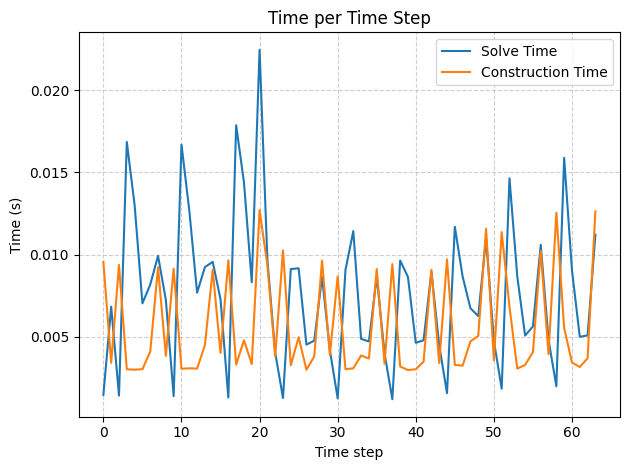

In [23]:
plt.plot(model._solve_time)
plt.plot(model._construction_time)
plt.xlabel("Time step")
plt.ylabel("Time (s)")
plt.title("Time per Time Step")
plt.legend(["Solve Time", "Construction Time"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


It would be helpful to run in paralell. This piece of code below is "old" and needs to be updated...

As an easy start, lets varify that the running time  $\Tau(a,s)$ is normally distributed;   
Here $a \in A$ is a specific solver, and $s \in S$ is a specific model set up. 

## Trying to do in in paralell:

In [25]:


# Number of parallel runs
n_runs = 10
n_jobs = -1  # use all CPUs


def run_single_solve(run_idx):
    # Safe deepcopy for thread safety (PETSc not shared between threads)
    model_copy = copy.deepcopy(model)

    t0 = time.time()
    pp.run_time_dependent_model(model_copy, {"prepare_simulation": False})
    t1 = time.time()

    wall_clock_time = t1 - t0

    # Read solver stats immediately after solve
    krylov_iters = getattr(model_copy, "_krylov_iters", None)
    petsc_reason = getattr(model_copy, "_petsc_converged_reason", None)
    construction_time = getattr(model_copy, "_construction_time", None)
    solve_time = getattr(model_copy, "_solve_time", None)

    return {
        "run": run_idx + 1,
        "wall_clock_time": wall_clock_time,
        "krylov_iterations": krylov_iters[-1],
        "petsc_converged_reason": petsc_reason[-1],
        "construction_time": construction_time[-1],
        "solve_time": solve_time[-1]
    }

# Use threading backend to avoid PETSc pickling issues
with parallel_backend("threading"):
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_solve)(i) for i in range(n_runs)
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show results
print(results_df)


   run  wall_clock_time  krylov_iterations  petsc_converged_reason  \
0    1         0.000314                 52                       2   
1    2         0.000319                 52                       2   
2    3         0.000189                 52                       2   
3    4         0.000169                 52                       2   
4    5         0.000342                 52                       2   
5    6         0.000284                 52                       2   
6    7         0.000180                 52                       2   
7    8         0.000202                 52                       2   
8    9         0.000527                 52                       2   
9   10         0.000330                 52                       2   

   construction_time  solve_time  
0           0.012626    0.011208  
1           0.012626    0.011208  
2           0.012626    0.011208  
3           0.012626    0.011208  
4           0.012626    0.011208  
5           0.01262

In [ ]:
results_df.plot(
    x='run',
    y=['construction_time', 'solve_time'],
    kind='line',
    marker='x',
    figsize=(10, 6),
    grid=True
)

import matplotlib.pyplot as plt
plt.ylabel('Time (seconds)')
plt.title('Solver timings')
plt.show()



In [ ]:
results_df['wall_clock_time'].plot(
    kind='hist',
    bins=20,
    title='Histogram of Wall Clock Time',
    figsize=(8, 5),
    grid=True
)